In [10]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

## Hypothesis Testing and Confidence Intervals 

Recall that for single variable datasets, it was usually not enough to simply compute a statistic such as a sample mean. For instance, if looking at a sample from a larger population. The sample mean will hopefully be close to the population mean, it probably won't be exactly the same. For this reason, we need to report not just the sample mean, but a confidence interval of plausible values for the population mean. 

Similarly, when performing an A/B-test it is not enough to report a difference in means between group A and group B, we also need to compute a $p$-value that indicates the probability the difference in means arose by random chance.

As we will see these concept both have an analogues for regressions. 

## Simple Linear Regressions.

It should be noted that the techniques we are about to use, will not always be statistically valid. There are a few things to check for before using the following techniques to test for significance or build a confidence interval for a linear regression. The most basic form of these assumptions is known as a "Linear Model with Equal Variance".

## Linear Model with Equal Variance

A Linear Model with Equal Variance means that the population are data is being drawn from satisfies the following assumptions


1.  If $\mu_{Y|X}$ is the average value of $Y$ among the subpopulation of values with $x=X$, then 

$$\mu_{Y|X} = \alpha + \beta X$$.

For instance if $Y$ is sale price and $X$ is square footage, then $\mu_{Y,2200}$ would be the average sale price of all 2200 square foot homes.  The first assumption says that there are numbers $\alpha$ and $\beta$, so that if we looked at all home sales, the average sale price of homes with square footage equal to $X$ would be given exactly by $\alpha+\beta X$ for any $X$.

2. If $\sigma_{Y|X}^2$ is the variance in $Y$ in the subpopulation of values with $x=X$, then $\sigma_{Y|X}^2$ doesn't depend on $X$, that is there is some number $\sigma$ so
$$ \sigma_{Y|X}^2 = \sigma^2$$.


For instance, if $Y$ is sale price and $X$ is square footage, then $\mu_{Y,2200}$ would be the variance in sale price among all $2200$ square foot homes. The second assumption says $\mu_{Y,2200}=\mu_{Y,X}$ for any other value of $X$.


## Diagnostics for Linear Model with Equal Variance.

We usually won't know for sure if the population our data comes from satisfies the Linear Model with Equal Variance. We discuss here a few behaviors of a data set that can confirm or contradict the assumptions of the model. 

### Linearity vs Non-linearity
 The first property our data must have is linearity, meaning that $\mu_{Y|X}$ is a linear function of $X$. Non-linearity occurs when the relationship between $X$ and $Y$ is not a linear one.  In this case, you may want to use another type of regression such a logistic or polynomial regression. Something we will talk about in a further chapter.

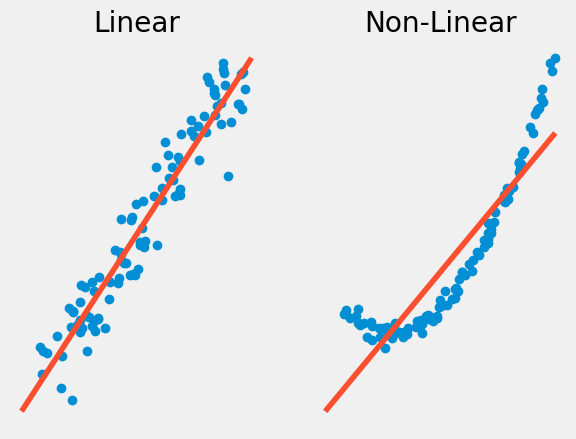

In [4]:
# generate homoskedastic data.
s_size = 100
a=-3
b=10
np.random.seed(346)
x_homsc = np.random.uniform(a,b,size=s_size)
y_homsc = x_homsc + np.random.normal(2,1,size=s_size)
p_hom = np.poly1d(np.polyfit(x_homsc,y_homsc,1))


fig, axs = plt.subplots(1, 2);


axs[0].plot(x_homsc, y_homsc, "o");
axs[0].plot(np.arange(a-1,b+1), p_hom(np.arange(a-1,b+1)), "-");
axs[0].set_title('Linear');
axs[0].axis('off');

# generate heteroskedastic data
x_het = np.random.uniform(a,b,size=s_size)
y_het = (x_het**2) + np.random.normal(0,2,size=s_size)
p_het = np.poly1d(np.polyfit(x_het,y_het,1))
axs[1].plot(x_het, y_het, "o");
axs[1].plot(np.arange(a-1,b+1), p_het(np.arange(a-1,b+1)), "-");
axs[1].set_title('Non-Linear');
axs[1].axis('off');

### Homoscedasticity vs. Heteroscedasticity

The second property our data must have is homoscedasticity, this means that the residuals of $y$ around the regression line stay the same as $x$ varies. Data that does not have this feature is heteroscedastic, while a lot of data sets have some heteroscedasticity, and a little bit might be acceptable, too much will harm the validity of the statistical analysis.


We can see examples of both types of behavior in the graphs below of a simulated data set. Note for the homoscedastic data, the residuals of $y$ around $x$ stay mostly the same. For heteroscedadstic data, for large $x$ values the $y$ values start to vary wildly around the regression line.

In terms of the model this means that the variance $\sigma_{Y|X}^2$ varies as $X$ changes.

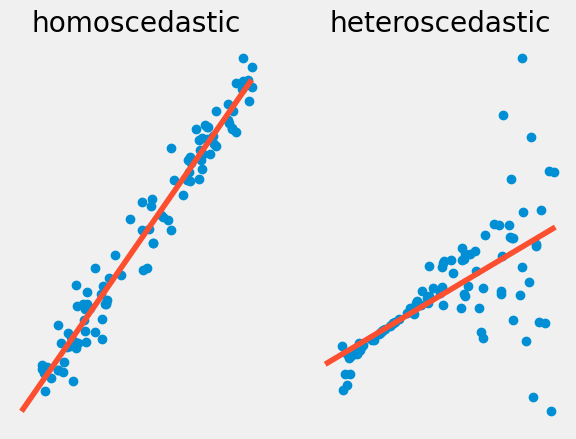

In [3]:
# generate homoskedastic data.
s_size = 100
a=-3
b=10
np.random.seed(344)
x_homsc = np.random.uniform(a,b,size=s_size)
y_homsc = x_homsc*0.5  + np.random.normal(5,0.5,size=s_size)
p_hom = np.poly1d(np.polyfit(x_homsc,y_homsc,1))


fig, axs = plt.subplots(1, 2);


axs[0].plot(x_homsc, y_homsc, "o");
axs[0].plot(np.arange(a-1,b+1), p_hom(np.arange(a-1,b+1)), "-");
axs[0].set_title('homoscedastic');
axs[0].axis('off');

# generate heteroskedastic data
x_het = np.random.uniform(a,b,size=s_size)
y_het = x_het*4  + 5 + (x_het**2)*np.random.normal(0,0.5,size=s_size)
p_het = np.poly1d(np.polyfit(x_het,y_het,1))
axs[1].plot(x_het, y_het, "o");
axs[1].plot(np.arange(a-1,b+1), p_het(np.arange(a-1,b+1)), "-");
axs[1].set_title('heteroscedastic');
axs[1].axis('off');

## Residuals 

A quick way to get a sense of potential heteroscedasticity in your data, is to look at the graph of residuals. Recall that for our regression function $f(x)$ the $i$-th residual is given by 
$$\epsilon_i = y_i-f(x_i).$$

We can graph the residuals for our housing data, and notice some heteroscedasticity, namely the variance seems to increase as square footage increases.

In [5]:
housing_df = pd.read_csv("../../data/Housing.csv")
housing_df.head()

def ols(x,y):
    """ Compute slope of OLS for two np.arrays"""
    #initialize to to NaN, incase we can't compute slope.
    beta,alpha = float("NaN"),float("NaN")
    x_bar = np.mean(x)
    y_bar = np.mean(y)
    beta = sum((x-x_bar)*(y-y_bar))/sum((x-x_bar)**2)
    alpha = y_bar-beta*x_bar
    return np.array([beta,alpha])

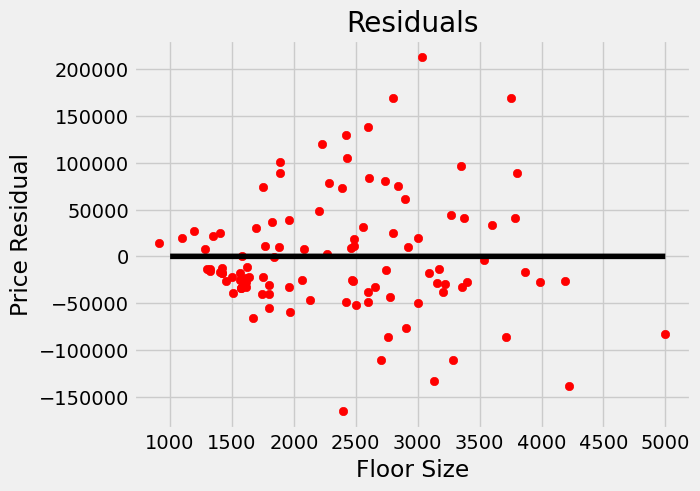

In [8]:
lin_regress   = ols(housing_df['floor_size'],housing_df['sold_price'])
lin_regress_p = (lambda t: t*lin_regress[0]+lin_regress[1])

residuals = housing_df['sold_price']-housing_df['floor_size'].apply(lin_regress_p)


plt.scatter(housing_df['floor_size'],residuals,color="red")
plt.xlabel("Floor Size")
plt.ylabel("Price Residual")
plt.title("Residuals")
plt.plot(np.arange(1000,5000), (np.arange(1000,5000))*0, "-",color="black");
plt.show()

### Diabetes Data Set

Since our first data set suffered from some heteroscedasticity. Let's take a look at another. This diabetes data set comes from https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html. It is a collection of health data from 442 diabetes patients. Looking at the residuals we see the data looks homoscedastic.

In [32]:
diabetes = pd.read_csv("diabetes.tsv",delimiter="\t")
diabetes

,AGE,SEX,BMI,BP,S1,S2,S3,S4,S5,S6,Y
0,59,2,32.1,101.00,157,93.2,38.0,4.00,4.8598,87,151
1,48,1,21.6,87.00,183,103.2,70.0,3.00,3.8918,69,75
2,72,2,30.5,93.00,156,93.6,41.0,4.00,4.6728,85,141
3,24,1,25.3,84.00,198,131.4,40.0,5.00,4.8903,89,206
4,50,1,23.0,101.00,192,125.4,52.0,4.00,4.2905,80,135
...,...,...,...,...,...,...,...,...,...,...,...
437,60,2,28.2,112.00,185,113.8,42.0,4.00,4.9836,93,178
438,47,2,24.9,75.00,225,166.0,42.0,5.00,4.4427,102,104
439,60,2,24.9,99.67,162,106.6,43.0,3.77,4.1271,95,132
440,36,1,30.0,95.00,201,125.2,42.0,4.79,5.1299,85,220


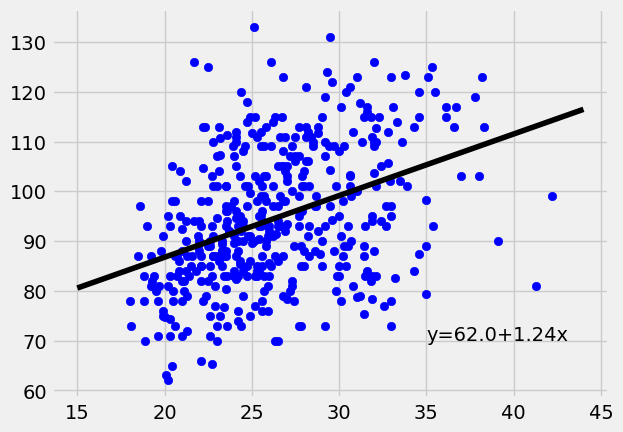

In [59]:
x = diabetes["BMI"]
y = diabetes["BP"]

lin_regress   = ols(x,y)
lin_regress_p = (lambda t: t*lin_regress[0]+lin_regress[1])




plt.scatter(x,y,color="blue")
plt.plot(np.arange(15,45), lin_regress_p(np.arange(15,45)), "-",color="black");

plt.text(x=35,y=70,s="y="+str(round(lin_regress[1],2))+"+"+str(round(lin_regress[0],2))+"x")
plt.show()

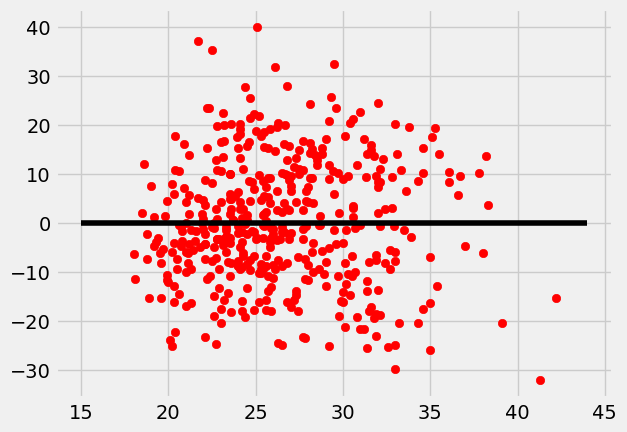

In [37]:
x = diabetes["BMI"]
y = diabetes["BP"]

lin_regress   = ols(x,y)
lin_regress_p = (lambda t: t*lin_regress[0]+lin_regress[1])

residuals = y-x.apply(lin_regress_p)


plt.scatter(x,residuals,color="red")

plt.plot(np.arange(15,45), np.arange(15,45)*0, "-",color="black");
plt.show()

## Bootstrap Confidence Intervals for Regression

Since our diabetes data set appears to satisfy the assumptions of linearity and heteroscedasticity we can proceed with building a basic bootstrap confidence interval for the slope of our regression line. Recall, the goal of the bootstrap confidence interval to build a confidence interval that contains the slope of the population regression. 

The code below simulates $1000$ samples of the original data set. We then compute the slope of the regression line, and store the difference between that and our sample slope in the bootstrap. Then use quantiles to compute the bounds of the interval.

In [47]:
sample_slope = ols(diabetes["BMI"],diabetes["BP"])[0]
boot_dist=[]

for i in range(1000):
    # single bootstrap resample
    boot = diabetes.sample(len(bmi_bp),replace=True)
    # compute bootstrap statistic
    boot_slope = ols(boot["BMI"],boot["BP"])[0]
    #store bootstrap statistic - sample statistic
    boot_dist.append(boot_slope-sample_slope)

# compute bounds for bootstrap distribution at 95% level
L0 = np.quantile(boot_dist,0.025)
U0 = np.quantile(boot_dist,0.975)

# print basic bootstrap interval
print("CI for slope at 95% level is ", [sample_slope-U0,sample_slope-L0])

CI for slope at 95% level is  [0.9708063789205976, 1.5500406515807061]


## Hypothesis Testing for Linear Regression.

Hypothesis Testing for Linear Regression, is a way to measure if there is a relationship between $X$ and $Y$ at all. Our hypothesis for a two sided-test would be as follows.

$$\begin{aligned}
H_0 &: \textrm{ There is no relationship between the value of $X$ and the mean value of $Y$}.\\
H_A &: \textrm{ There is some linear relationship between the value of $X$ and the mean value of $Y$}.
\end{aligned}$$

If we assume we have a Linear Model with Equal Variance, with $\mu_{Y|X} = \alpha+\beta X$ then these hypothesis can be stated as follows

$$\begin{aligned}
H_0 &:  \beta =0.\\
H_A &: \beta \neq 0.
\end{aligned}$$

Of course these could be modified to allow for one sided hypothesis testing as well.

If there is no relationship between $X$ and $Y$, then any observed relationship is a result of random chance. In this scenario permuting the $Y$-values would give us a new dataset that was just as likely as our observed data set. Repeating this process and compute the slope of the observed regression lines gives us a distribution of slopes under the null hypothesis. We compare this distribution to our initial observed slope to compute a $p$-value.

The code below computes the $p$-value for the diabetes dataset. 

In [48]:
sample_slope = ols(diabetes["BMI"],diabetes["BP"])[0]
null_slopes=[]

for i in range(1000):
    # single bootstrap resample
    shuffled_bp = np.random.choice(diabetes["BP"],len(diabetes["BP"]),replace=False)
    # compute bootstrap statistic
    shuffled_slope = ols(boot["BMI"],shuffled_bp)[0]
    #store bootstrap statistic - sample statistic
    null_slopes.append(shuffled_slope)

#compute $p$-value for two sided test
(sum(np.abs(np.array(null_slopes)) >= sample_slope))/1000

0.0

In the above example our estimated $p$-value is $0$. As we only did $1000$ samples this tells us our $p$-value is less than $1/1000$